In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
folder_path = 'E:/work/data/waze-trafmine/2018/4'

In [3]:
def from_json_folder_to_json_docs(folder_path):
    pathlist = Path(folder_path).glob('**/*.json')
    json_docs = []
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        print('processing file: ' + path_in_str)
        with open(path_in_str, encoding="utf8") as f:
            json_file = json.load(f)
            json_docs.append(json_file)
    print('Done!')
    return json_docs

In [4]:
json_data = from_json_folder_to_json_docs(folder_path)

processing file: E:\work\data\waze-trafmine\2018\4\1-10.json
processing file: E:\work\data\waze-trafmine\2018\4\11-20.json
processing file: E:\work\data\waze-trafmine\2018\4\21-30.json
Done!


In [5]:
first_it = True
for json in json_data:
    #print(json.keys())
    if first_it != True:
        alerts_df.append(pd.DataFrame(json['alerts']), ignore_index=True)
        jams_df.append(pd.DataFrame(json['jams']), ignore_index=True)
    else:
        alerts_df = pd.DataFrame(json['alerts'])
        jams_df = pd.DataFrame(json['jams'])
        first_it = False

In [6]:
alerts_df.head(3)

,alert_subtype_id,alert_type_id,city,confidence,country,jam_uuid,last_seen,location,magvar,publish_date,reliability,report_by_partner,report_description,report_rating,road_type,street,thumbs_up,uuid
0,13.0,4,None,5,CI,None,2018-04-01T03:00:21+00:00,"[-70.646227, -33.635035]",265,2018-04-01T01:02:02+00:00,10,None,None,0,3.0,Ruta 79,0,8271e6bf-fca0-3cad-bac4-6a6959d16b1c
1,4.0,3,Conchalí,0,CI,None,2018-04-01T03:00:21+00:00,"[-70.670608, -33.398605]",56,2018-04-01T02:30:58+00:00,5,None,None,1,2.0,Av. Dorsal,0,e7b8841f-a144-3b7d-b685-05bc447b73fd
2,3.0,3,Ñuñoa,0,CI,None,2018-04-01T03:00:21+00:00,"[-70.575705, -33.469535]",2,2018-04-01T02:31:00+00:00,5,None,None,1,2.0,None,0,e1c149d5-4383-3490-bb2d-550156e3ad51


In [7]:
alerts_df.shape

(115547, 18)

In [8]:
# parse date to datetime object
alerts_df['publish_date_dt'] = pd.to_datetime(alerts_df['publish_date'])

In [9]:
# subsets dataframe
alerts_df.drop(alerts_df.columns.difference(['alert_subtype_id', 'alert_type_id', 'street', 'publish_date_dt']), 1, inplace=True)

In [10]:
# drop duplicates
alerts_df.drop_duplicates(inplace=True)

In [11]:
# drop nans from alert_subtype_id, street
alerts_df.dropna(subset=['alert_subtype_id','street'], inplace=True)

In [12]:
# sort by date just in case
alerts_df.sort_values(by=['publish_date_dt'])

,alert_subtype_id,alert_type_id,street,publish_date_dt
115496,7.0,4,Alberto Llona,2016-08-06 17:55:23+00:00
115542,7.0,4,Manuel Antonio Matta,2017-01-14 15:01:37+00:00
115497,7.0,4,Manuel Antonio Matta,2017-01-14 16:01:37+00:00
115543,7.0,4,Av. Independencia,2017-02-14 12:40:23+00:00
115498,7.0,4,Av. Independencia,2017-02-14 13:40:23+00:00
115526,33.0,7,Carrión,2018-01-17 15:41:09+00:00
115472,33.0,7,Los Nidos,2018-01-18 06:50:16+00:00
115473,33.0,7,Los Nidos,2018-02-18 17:16:39+00:00
115527,33.0,7,Carrión,2018-02-18 19:41:11+00:00
115520,33.0,7,Salida 19B > Núcleo Empresarial,2018-02-21 13:58:28+00:00


In [13]:
# set date as index, not sure if good idea
#alerts_df = alerts_df.set_index('publish_date_dt').sort_index()

In [14]:
alerts_df.head(3)

,alert_subtype_id,alert_type_id,street,publish_date_dt
0,13.0,4,Ruta 79,2018-04-01 01:02:02+00:00
1,4.0,3,Av. Dorsal,2018-04-01 02:30:58+00:00
3,30.0,4,Av. Américo Vespucio Sur,2018-04-01 02:47:19+00:00


In [15]:
alerts_df.shape

(106885, 4)

In [16]:
alerts_df['alert_type_id'].value_counts().plot(kind='barh')

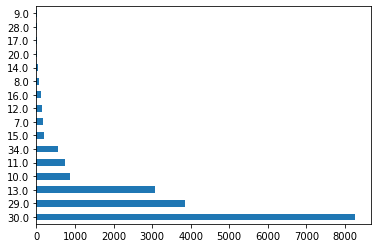

In [17]:
alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].value_counts().plot(kind='barh')

In [18]:
print(np.sort(alerts_df['alert_subtype_id'].unique()))

[ 1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28.
 29. 30. 31. 32. 33. 34.]


In [19]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 2].unique()))

[1. 2.]


In [20]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 3].unique()))

[3. 4. 5.]


In [21]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].unique()))

[ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28. 29. 30. 34.]


In [22]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 7].unique()))

[31. 32. 33.]


I have to assume that 'alert_type_id' is 3 (JAM) and 'alert_subtype_id' 4 is JAM_HEAVY_TRAFFIC and 5 is JAM_STAND_STILL_TRAFFIC

In [23]:
alerts_df['street'].unique().shape

(3140,)

In [24]:
# res_df = alerts_df[:200].apply(lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
#                                                                (alerts_df['publish_date_dt'] <= row['publish_date_dt']) & 
#                                                                (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta(minutes=30))])
#                , axis = 1)

In [33]:
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster, asynchronous=True,
                memory_limit='10GB')

ddata = dd.from_pandas(alerts_df, npartitions=36)

alerts_df['seq'] = ddata.map_partitions(lambda df: df.apply((lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
                                                               (alerts_df['publish_date_dt'] < row['publish_date_dt']) & 
                                                               (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta('00:30:00'))]))
                                                , axis=1)).compute(scheduler=client)

C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_env\lib\site-packages\distributed\bokeh\core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [WinError 10048] Solo se permite un uso de cada dirección de socket (protocolo/dirección de red/puerto)
  warnings.warn("\n" + msg)


In [34]:
alerts_df.head()

,alert_subtype_id,alert_type_id,street,publish_date_dt,seq
0,13.0,4,Ruta 79,2018-04-01 01:02:02+00:00,[]
1,4.0,3,Av. Dorsal,2018-04-01 02:30:58+00:00,[]
3,30.0,4,Av. Américo Vespucio Sur,2018-04-01 02:47:19+00:00,[]
4,30.0,4,Vicente Reyes,2018-04-01 02:21:05+00:00,[]
5,1.0,2,Ruta 79,2018-04-01 02:33:36+00:00,[]


In [40]:
alerts_df_w_seq = alerts_df[alerts_df.astype(str)['seq'] != '[]']

In [41]:
alerts_df_w_seq.head()

,alert_subtype_id,alert_type_id,street,publish_date_dt,seq
27,7.0,4,Autopista Central,2018-04-01 02:54:35+00:00,[3.0]
30,13.0,4,Av. Américo Vespucio,2018-04-01 03:09:19+00:00,[4.0]
40,1.0,2,Av. Américo Vespucio,2018-04-01 03:22:09+00:00,[13.0]
53,29.0,4,Autopista Central - Eje General Velázquez,2018-04-01 03:44:16+00:00,[15.0]
57,30.0,4,Ruta 78 / Autopista del Sol,2018-04-01 04:21:51+00:00,[13.0]


In [42]:
alerts_df_w_seq.shape

(72528, 5)

In [39]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].head(10)

,alert_subtype_id,alert_type_id,street,publish_date_dt,seq
60,4.0,3,Antonia López de Bello,2018-04-01 04:07:34+00:00,[4.0]
78,5.0,3,Antonia López de Bello,2018-04-01 04:56:23+00:00,[4.0]
177,5.0,3,Boulevard Lyon Juana de Arco,2018-04-01 12:06:15+00:00,[30.0]
268,4.0,3,Ruta 78 / Autopista del Sol,2018-04-01 14:10:44+00:00,"[13.0, 13.0, 13.0, 13.0]"
278,4.0,3,Av. Camilo Henríquez,2018-04-01 14:23:36+00:00,[4.0]
280,4.0,3,Av. Camilo Henríquez,2018-04-01 14:25:08+00:00,"[4.0, 4.0]"
288,4.0,3,Ruta 78 / Autopista del Sol,2018-04-01 14:34:15+00:00,"[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 4.0, 3.0,..."
299,5.0,3,Pío Nono,2018-04-01 14:45:12+00:00,[3.0]
300,4.0,3,Av. Camilo Henríquez,2018-04-01 14:45:15+00:00,"[4.0, 4.0, 4.0]"
320,4.0,3,Av. Recoleta,2018-04-01 15:04:32+00:00,[4.0]


In [37]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].shape

(50779, 5)

In [44]:
alerts_df_w_seq['label'] = np.where((alerts_df_w_seq['alert_type_id'] == 3) &
                                    ((alerts_df_w_seq['alert_subtype_id'] == 4) | (alerts_df_w_seq['alert_subtype_id'] == 5)) &
                                    (alerts_df_w_seq.astype(str)['seq'] != '[]'), 1, 0)

C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
alerts_df_w_seq.head()

,alert_subtype_id,alert_type_id,street,publish_date_dt,seq,label
27,7.0,4,Autopista Central,2018-04-01 02:54:35+00:00,[3.0],0
30,13.0,4,Av. Américo Vespucio,2018-04-01 03:09:19+00:00,[4.0],0
40,1.0,2,Av. Américo Vespucio,2018-04-01 03:22:09+00:00,[13.0],0
53,29.0,4,Autopista Central - Eje General Velázquez,2018-04-01 03:44:16+00:00,[15.0],0
57,30.0,4,Ruta 78 / Autopista del Sol,2018-04-01 04:21:51+00:00,[13.0],0


In [ ]:
alerts_df_jams = alerts_df[(alerts_df['alert_type_id'] == 3) & ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5))]

In [ ]:
alerts_df_jams.head()